In [34]:
import kagglehub
from pathlib import Path

dataset_dir = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")
print("📁 Dataset downloaded at:", dataset_dir)


📁 Dataset downloaded at: /kaggle/input/diabetic-retinopathy-224x224-2019-data


In [35]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

from timm import create_model
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [36]:
import os

# See actual downloaded path
print("Dataset Dir:", dataset_dir)

# List contents of root dataset folder
print("\n📁 Top level folders/files:")
print(os.listdir(dataset_dir))

# If there's a subfolder, list it
for root, dirs, files in os.walk(dataset_dir):
    print(f"\n📂 In folder: {root}")
    for d in dirs:
        print("📁", d)
    for f in files[:5]:
        print("📄", f)
    break


Dataset Dir: /kaggle/input/diabetic-retinopathy-224x224-2019-data

📁 Top level folders/files:
['colored_images', 'train.csv']

📂 In folder: /kaggle/input/diabetic-retinopathy-224x224-2019-data
📁 colored_images
📄 train.csv


Step by Step Code for VIT preTrained model


In [37]:
!pip install -q kagglehub transformers timm grad-cam


In [38]:
import kagglehub
from pathlib import Path

# Download dataset using kagglehub
dataset_dir = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")
print("📁 Dataset downloaded at:", dataset_dir)


📁 Dataset downloaded at: /kaggle/input/diabetic-retinopathy-224x224-2019-data


In [39]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ Use the correct path now
data_path = os.path.join("/kaggle/input/diabetic-retinopathy-224x224-2019-data", "colored_images")

# Load dataset
full_dataset = ImageFolder(data_path, transform=transform)

# Split 80% train / 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Class names
class_names = full_dataset.classes
print("✅ Classes:", class_names)
print(f"📊 Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


✅ Classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
📊 Train size: 2929, Val size: 733


In [40]:
import torch.nn as nn
from timm import create_model

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)

# Load pre-trained ViT
vit_model = create_model("vit_base_patch16_224", pretrained=True, num_classes=5)
vit_model = vit_model.to(device)


🚀 Using device: cuda


In [41]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

# Training loop
def train_model(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"📚 Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

train_model(vit_model, train_loader, val_loader, epochs=3)


📚 Epoch 1/3 - Loss: 0.9065
📚 Epoch 2/3 - Loss: 0.7218
📚 Epoch 3/3 - Loss: 0.6487


In [42]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Validation Accuracy: {accuracy:.2f}%")

evaluate_model(vit_model, val_loader)


✅ Validation Accuracy: 73.67%


In [43]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet50
resnet_model = models.resnet50(pretrained=True)

# Modify final fully connected layer for 5 classes
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)

# Move model to device
resnet_model = resnet_model.to(device)

print("✅ ResNet50 loaded and modified for 5-class classification.")


✅ ResNet50 loaded and modified for 5-class classification.


In [44]:
from torch import optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=2e-4)

# Training loop
epochs = 3
for epoch in range(epochs):
    resnet_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"📚 Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


📚 Epoch 1/3 - Loss: 0.6694
📚 Epoch 2/3 - Loss: 0.4648
📚 Epoch 3/3 - Loss: 0.3671


In [45]:
resnet_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

resnet_acc = 100 * correct / total
print(f"📊 ResNet50 Validation Accuracy: {resnet_acc:.2f}%")


📊 ResNet50 Validation Accuracy: 81.72%


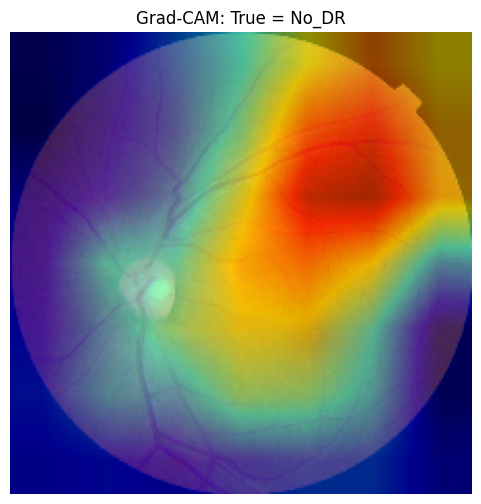

In [46]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import matplotlib.pyplot as plt

# Get one image from validation set
resnet_model.eval()
images, labels = next(iter(val_loader))
image_tensor = images[0].unsqueeze(0).to(device)
image_np = images[0].permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Target last ResNet conv block
target_layer = resnet_model.layer4[-1]

# Initialize GradCAM (no `use_cuda`)
cam = GradCAM(model=resnet_model, target_layers=[target_layer])
cam.batch_size = 1  # explicitly set if needed

# Generate Grad-CAM heatmap
grayscale_cam = cam(input_tensor=image_tensor)[0]

# Overlay CAM
cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

# Display result
plt.figure(figsize=(6, 6))
plt.imshow(cam_image)
plt.title(f"Grad-CAM: True = {class_names[labels[0]]}")
plt.axis('off')
plt.show()


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_vit_attention(model, image_tensor, image_np, class_names, true_label):
    """
    Visualize attention maps for a timm Vision Transformer
    """
    # Hook to capture attention
    attention = None

    def hook_fn(module, input, output):
        nonlocal attention
        # Different timm versions have different attention outputs
        if isinstance(output, tuple):
            attention = output[1]  # Newer timm versions
        else:
            # For older versions, we need to compute attention manually
            B, N, C = input[0].shape
            qkv = module.qkv(input[0]).reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv.unbind(0)
            attn = (q @ k.transpose(-2, -1)) * module.scale
            attention = attn.softmax(dim=-1)

    # Register hook to the last attention layer
    handle = model.blocks[-1].attn.register_forward_hook(hook_fn)

    # Forward pass
    with torch.no_grad():
        model(image_tensor)

    # Remove hook
    handle.remove()

    if attention is not None:
        # Process attention maps
        # Average attention across heads
        attention = attention.mean(dim=1)[:, 0, 1:]  # Class token to patches

        # Reshape to 2D grid
        patch_size = int(np.sqrt(attention.shape[-1]))
        attention = attention.reshape(-1, patch_size, patch_size)

        # Upsample to input size
        attention = F.interpolate(attention.unsqueeze(1),
                                size=image_np.shape[:2],
                                mode='bicubic',
                                align_corners=False).squeeze(1)

        # Normalize
        attention = attention - attention.min()
        attention = attention / attention.max()
        grayscale_cam = attention.cpu().numpy()[0]

        # Overlay CAM
        cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

        # Display result
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f"Original Image\nTrue Class: {class_names[true_label]}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cam_image)
        plt.title("ViT Attention Heatmap")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Failed to capture attention maps")

# Get one image from validation set
vit_model.eval()
images, labels = next(iter(val_loader))
image_tensor = images[0].unsqueeze(0).to(device)
image_np = images[0].permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Visualize attention
visualize_vit_attention(vit_model, image_tensor, image_np, class_names, labels[0].item())

AttributeError: 'Attention' object has no attribute 'attn_probs'